In [8]:
from google.colab import drive

In [9]:
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
file_path = '/content/drive/My Drive/Colab Notebooks/cleaned_training_data.csv'

In [11]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [13]:
from imblearn.over_sampling import SMOTE

In [14]:
data = pd.read_csv(file_path,  header=0)

In [21]:
# Subsample the majority class
data_majority = data[data['bad_flag'] == 0]
data_minority = data[data['bad_flag'] == 1]

# Downsample majority class
data_majority_downsampled = data_majority.sample(2*len(data_minority), random_state=42)

data_balanced = pd.concat([data_majority_downsampled, data_minority])

# Shuffle the balanced dataset
data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

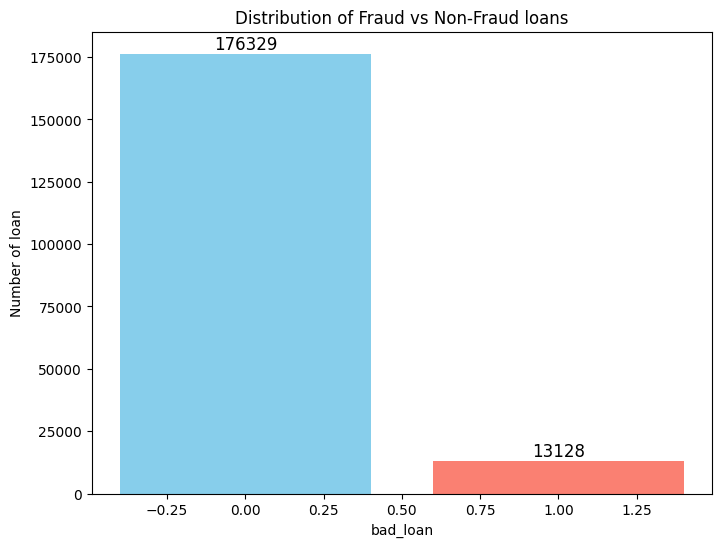

In [15]:
fraud_counts = data['bad_flag'].value_counts()
plt.figure(figsize=(8, 6))
bars = plt.bar(fraud_counts.index, fraud_counts.values, color=['skyblue', 'salmon'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 100, str(yval), ha='center', va='bottom', fontsize=12)

plt.xlabel('bad_loan')
plt.ylabel('Number of loan')
plt.title('Distribution of Fraud vs Non-Fraud loans')

plt.show()    ## show distribution of fraud and non-fraud

In [16]:
y = data['bad_flag'].astype(float)
X = data.drop(columns=['bad_flag', 'bc_util'])

In [17]:
# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [18]:

smote = SMOTE(sampling_strategy=0.8, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

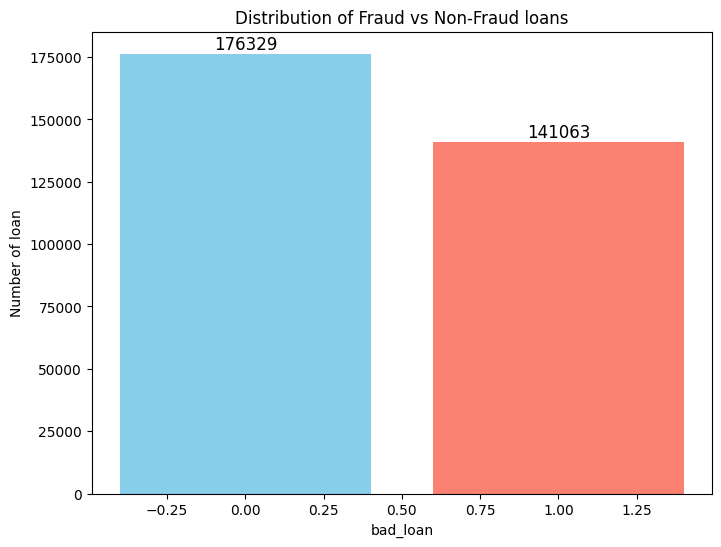

In [19]:
fraud_counts = y_resampled.value_counts()
plt.figure(figsize=(8, 6))
bars = plt.bar(fraud_counts.index, fraud_counts.values, color=['skyblue', 'salmon'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 100, str(yval), ha='center', va='bottom', fontsize=12)

plt.xlabel('bad_loan')
plt.ylabel('Number of loan')
plt.title('Distribution of Fraud vs Non-Fraud loans')

plt.show()    ## show distribution of fraud and non-fraud

In [20]:


# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [21]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

In [33]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        # self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        # self.dropout2 = nn.Dropout(p=0.15)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        # x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        # x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

# Model configuration
input_size = X_train.shape[1]
print(input_size)
hidden_size1 = 128  # Configurable
hidden_size2 = 64
hidden_size3 = 32
output_size = 1

# Instantiate the model
model = NeuralNet(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)

28


In [35]:
# Training loop
epochs = 100  # Configurable
batch_size = 64
# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


In [28]:
best_val_loss = float('inf')
early_stop_counter = 0
patience = 15  # Stop training if no improvement in 10 consecutive epochs

In [ ]:

for epoch in range(epochs):
    optimizer.step()
    scheduler.step()


    # # Early stopping
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     early_stop_counter = 0
    #     torch.save(model.state_dict(), "best_model.pth")  # Save the best model
    # else:
    #     early_stop_counter += 1

    # if early_stop_counter >= patience:
    #     print("Early stopping triggered!")
    #     break

    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        # Get mini-batch
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]

        # Forward pass
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        train_outputs = model(X_train_tensor).squeeze()
        train_predictions = (train_outputs > 0.5).float()
        train_accuracy = accuracy_score(y_train_tensor.numpy(), train_predictions.numpy())

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor).squeeze()
        val_loss = criterion(val_outputs, y_val_tensor)
        val_predictions = (val_outputs > 0.5).float()
        val_accuracy = accuracy_score(y_val_tensor.numpy(), val_predictions.numpy())

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}")

# Save the model
# torch.save(model.state_dict(), "neural_net_model.pth")